# Estimation de Mouvement

### Importation des bibliothèques nécessaires

In [1]:
#!pip install matplotlib
#!pip install numpy

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches

### Visualisation des images données à l'étude

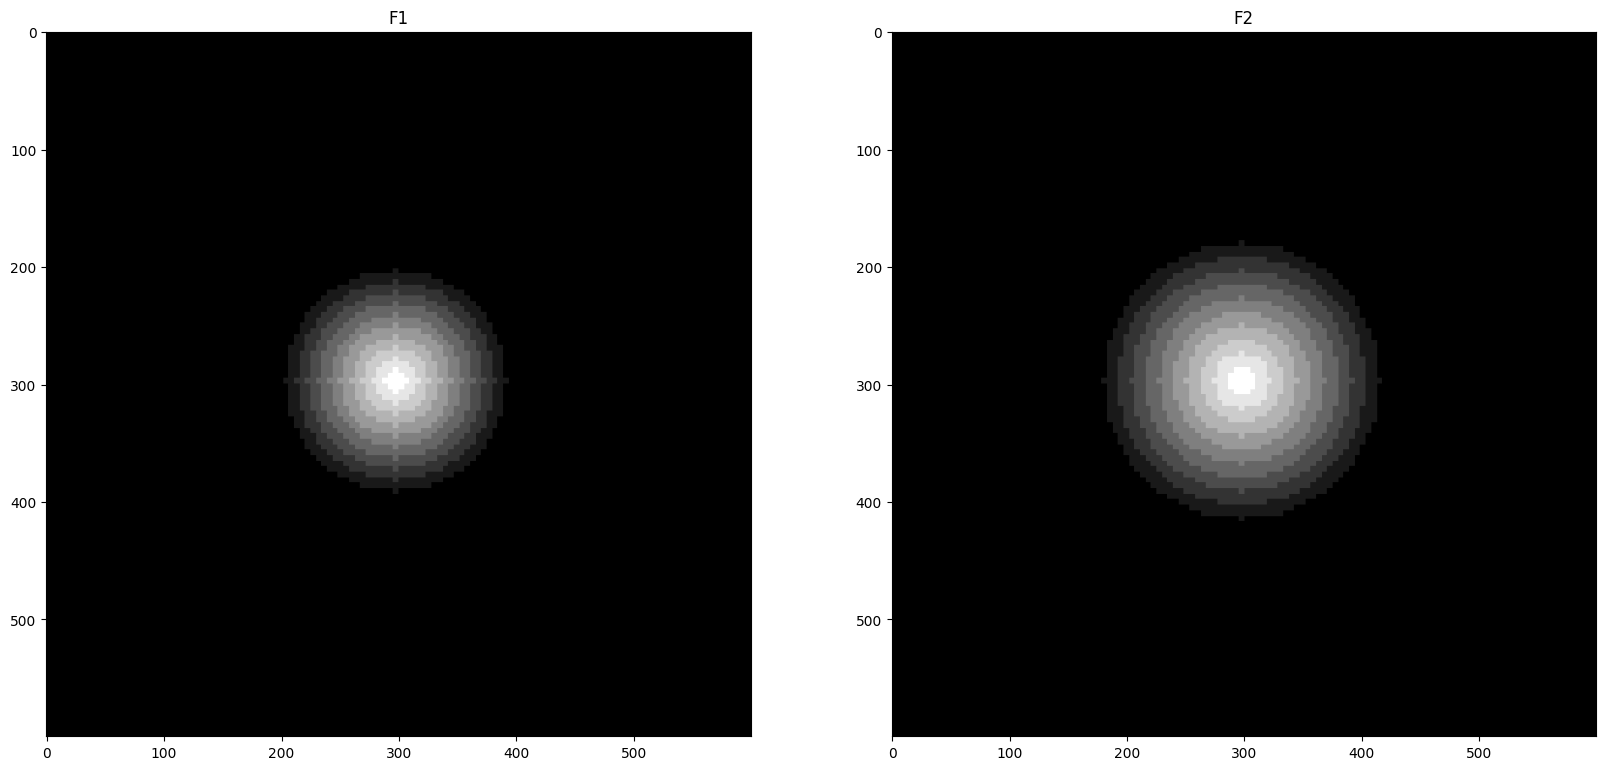

In [2]:
# Load images
img1 = mpimg.imread('F1.png').mean(axis=2)
img2 = mpimg.imread('F2.png').mean(axis=2)

# Display images
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.imshow(img1, cmap='gray')
plt.title('F1')

plt.subplot(1, 2, 2)
plt.imshow(img2, cmap='gray')
plt.title('F2')

plt.show()

### (A) Partant de deux frames F1 et F2 où F2 succède à F1 dans le temps, estimez par une methode pixel-wise les vecteurs de mouvements des pixels de la frame F1 vers F2 (en admettant l’hypothèse de l’intensité constante).

### Estimation de Mouvement - Méthode Pixel-Wise

Dans cette section, nous allons estimer les vecteurs de mouvement des pixels de la frame F1 vers F2 en utilisant une méthode pixel-wise, en supposant l'hypothèse de l'intensité constante.

### Hypothèse de l'Intensité Constante

L'hypothèse de l'intensité constante suppose que l'intensité lumineuse d'un pixel reste constante entre deux frames consécutives. En d'autres termes, pour un pixel donné $(x,y)$ à un instant $t$, nous avons :

$$\psi(x,y,t)=\psi(x+u,y+v,t+1)$$

où $u$ et $v$ sont les composantes du vecteur de mouvement à estimer.

### Implémentation de la Méthode Pixel-Wise

Nous allons utiliser la méthode du flux optique. Cela revient à utiliser les gradients de l'image pour estimer les vecteurs de mouvement. La méthode que nous allons utiliser est basée sur le calcul des dérivées spatiales et temporelles des images.

$$
\frac{\partial \psi}{\partial x}u + \frac{\partial \psi}{\partial y}v + \frac{\partial \psi}{\partial t} = 0
$$

Pour chaque pixel (sauf ceux proches des bords), nous considérons une petite fenêtre centrée sur ce pixel dont le but est de trouver les coordonnées de celui qui satisafait l'équation dans la frame2. La taille de cette fenêtre est déterminée par `window_size`.

**Résolution du Système d'Équations**:

Soient $A$ la matrice représentant la fenêtre des gradients $x$ et $y$ centrés sur un pixel précis de la frame1, et $b$ la matrice représentant la fenêtre du gradient entre la frame2 et la frame1 centrée sur un pixel précis:

Si $A$ a un rang suffisant (donc n'est pas composé uniquement de 0), nous résolvons le système d'équations linéaires $A * uv = b$ en utilisant la méthode des moindres carrés pour obtenir les vecteurs de déplacement $u$ et $v$.

In [3]:
def estimate_optical_flow(frame1, frame2, window_size=5):
    Ix = np.gradient(frame1, axis=1)
    Iy = np.gradient(frame1, axis=0)
    It = frame2 - frame1

    u = np.zeros_like(frame1)
    v = np.zeros_like(frame1)

    half_window = window_size // 2
    for y in range(half_window, frame1.shape[0] - half_window):
        for x in range(half_window, frame1.shape[1] - half_window):
            Ix_window = Ix[y - half_window:y + half_window + 1, x - half_window:x + half_window + 1].flatten()
            Iy_window = Iy[y - half_window:y + half_window + 1, x - half_window:x + half_window + 1].flatten()
            It_window = It[y - half_window:y + half_window + 1, x - half_window:x + half_window + 1].flatten()

            A = np.vstack((Ix_window, Iy_window)).T
            b = -It_window.reshape((-1, 1))

            if np.linalg.matrix_rank(A) >= 1:
                uv, _, _, _ = np.linalg.lstsq(A, b, rcond=None)
                u[y, x] = uv[0][0]
                v[y, x] = uv[1][0]

    return u, v

u, v = estimate_optical_flow(img1, img2, window_size=5)

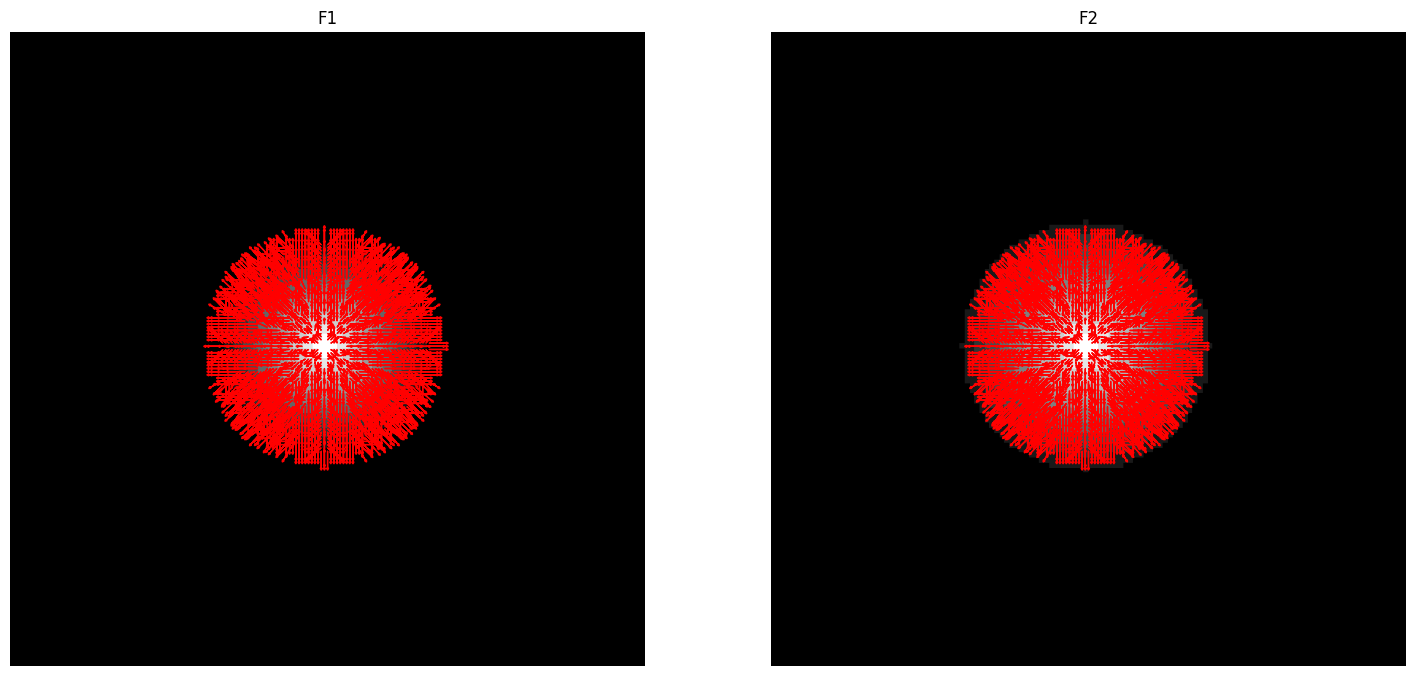

In [4]:
def display_optical_flow(img1, img2, u, v, scale=4, stride=3, zoom=0):
    _, axes = plt.subplots(1, 2, figsize=(18, 9))

    axes[0].imshow(img1, cmap='gray')
    axes[0].set_title('F1')
    axes[0].axis('off')

    axes[1].imshow(img2, cmap='gray')
    axes[1].set_title('F2')
    axes[1].axis('off')

    # Plotting movement vectors
    for y in range(0, img1.shape[0], stride):
        for x in range(0, img1.shape[1], stride):
            if np.abs(u[y, x]) < 1e-7 and np.abs(v[y, x]) < 1e-7:
                continue
            axes[0].arrow(x, y, u[y, x] * scale, v[y, x] * scale, color='red', head_width=2, head_length=2)
            axes[1].arrow(x, y, u[y, x] * scale, v[y, x] * scale, color='red', head_width=2, head_length=2)

    if zoom == 1:
        axes[0].set_xlim(175, 425)
        axes[0].set_ylim(175, 425)
        axes[1].set_xlim(175, 425)
        axes[1].set_ylim(175, 425)
    if zoom == 2:
        axes[0].set_xlim(225, 375)
        axes[0].set_ylim(225, 375)
        axes[1].set_xlim(225, 375)
        axes[1].set_ylim(225, 375)
    plt.show()

display_optical_flow(img1, img2, u, v)

Zoomons pour voir plus dans les détails:

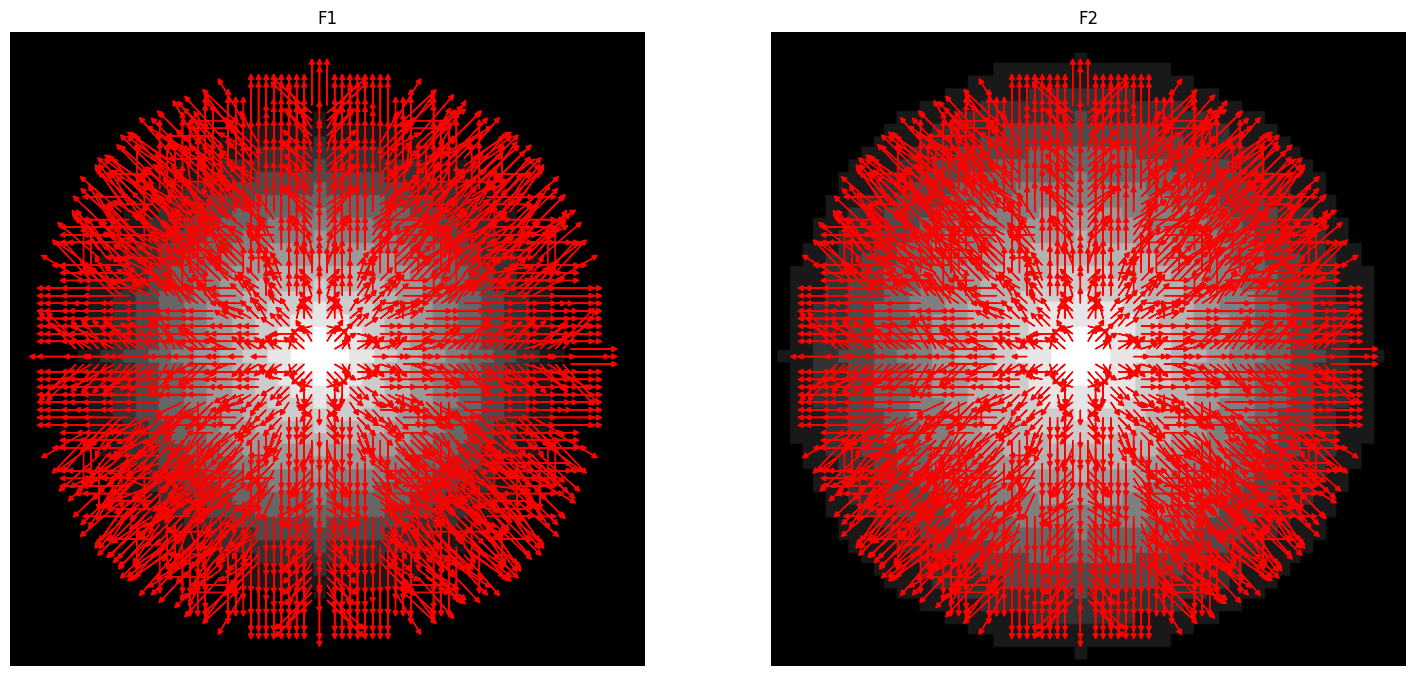

In [5]:
display_optical_flow(img1, img2, u, v, zoom=True)

Encore plus de zoom, et on réduit le stride pour voir chaque détail:

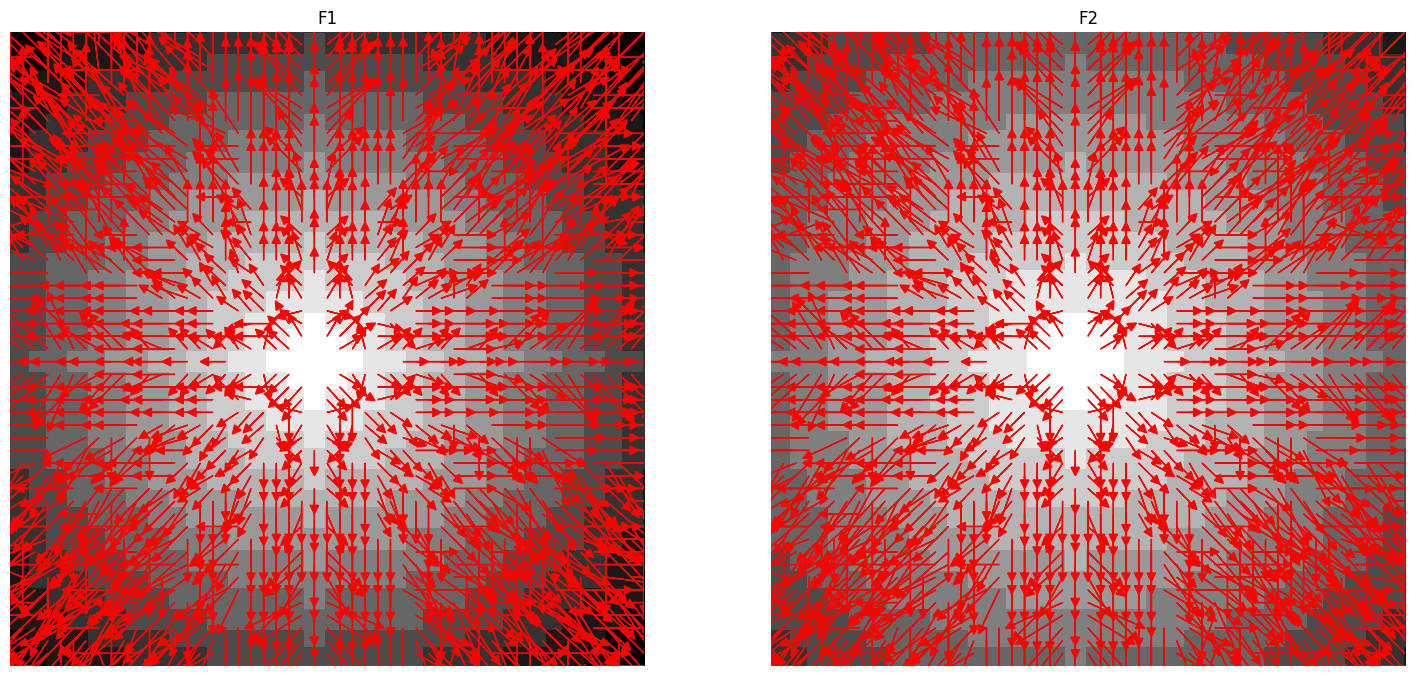

In [6]:
display_optical_flow(img1, img2, u, v, stride=3, zoom=2)

Ici on affiche les vecteurs à la fois sur F1, puis su F2 pour pouvoir visuellement comparer les origines et sorties des vecteurs.

Les vecteurs de mouvement obtenus par cette méthode sont basés sur les gradients locaux et la différence d'intensité entre les deux frames. Les vecteurs affichés montrent la direction et la magnitude du mouvement des pixels de `F1` vers `F2`.

## (B) Refaire cette même estimation par blocs (BMA) pour différentes tailles de blocs.

### Estimation de Mouvement - Méthode Block Matching (BMA)

Cette méthode consiste à diviser l'image en blocs et à trouver le déplacement optimal pour chaque bloc en minimisant une fonction de coût.

### Hypothèse et Démarche

La méthode Block Matching repose sur l'hypothèse que le déplacement des blocs d'image entre deux frames successives peut être approximé par la recherche du bloc correspondant dans une fenêtre de recherche dans la deuxième image.

Soit $B(i,j)$ un bloc de l'image $\psi_{1}$ centré en $(i,j)$. Pour chaque bloc $B$ dans l'image $\psi_{1}$, nous cherchons le bloc correspondant $B′$ dans $\psi_{2}$​ tel que l'erreur $E$ soit minime:
$$E=minimize∑_{(x,y)∈B}∣\psi_{1}(x,y)−\psi_{1}(x+u,y+v)∣$$
où $u$ et $v$ sont les déplacements horizontaux et verticaux respectivement, et la somme est prise sur tous les pixels $(x,y)$ du bloc $B$.

In [7]:
def find_min_coordinates(matrix, window_size):
    min_value = float('inf')
    min_distance = float('inf')
    min_coords = None

    center = (window_size + 1, window_size + 1)

    for i in range(len(matrix)):
        for j in range(len(matrix[0])):
            if matrix[i][j] < min_value:
                min_value = matrix[i][j]
                min_coords = (i, j)
                min_distance = abs(i - center[0]) + abs(j - center[1])
            elif matrix[i][j] == min_value:
                distance = abs(i - center[0]) + abs(j - center[1])
                if distance < min_distance:
                    min_coords = (i, j)
                    min_distance = distance

    return min_coords

La fonction `find_min_coordinates` parcourt une matrice de coûts pour trouver les coordonnées du coût minimum par rapport au centre. En cas d'égalité des coûts, elle sélectionne le bloc le plus proche du centre de la fenêtre de recherche. Cela sert notamment à éviter qu'un déplacement par défaut soit utilisé en cas d'égalité (en haut à gauche: cela est lié au parcourt par défaut des éléments de la matrice qui se fait du haut à gauche vers la droite en bas).

In [8]:
def block_matching(frame1, frame2, block_size=20, search_range=20):
    height, width = frame1.shape
    flow_u = np.zeros((height // block_size, width // block_size))
    flow_v = np.zeros((height // block_size, width // block_size))
    modified_blocks = np.zeros((height // block_size, width // block_size), dtype=bool)

    for i in range(0, height - block_size + 1, block_size):
        for j in range(0, width - block_size + 1, block_size):
            best_match = (0, 0)
            current_block = frame1[i:i+block_size, j:j+block_size]
            all_cost = np.zeros((search_range * 2 + 1, search_range * 2 + 1))

            for y in range(-search_range, search_range + 1):
                for x in range(-search_range, search_range + 1):
                    ref_i = i + y
                    ref_j = j + x

                    if 0 <= ref_i <= height - block_size and 0 <= ref_j <= width - block_size:
                        ref_block = frame2[ref_i:ref_i+block_size, ref_j:ref_j+block_size]
                        cost = np.sum(np.abs(ref_block - current_block))
                        all_cost[y + search_range, x + search_range] = cost

            #min_index = np.unravel_index(np.argmin(all_cost), all_cost.shape)
            min_index = find_min_coordinates(all_cost, search_range)

            min_cost = all_cost[min_index[0], min_index[1]]
            current_block = all_cost[search_range + 1, search_range + 1]
            best_match = (min_index[0] - search_range, min_index[1] - search_range)

            if min_cost != current_block and np.linalg.norm(best_match) > 5:
                flow_u[i // block_size, j // block_size] = best_match[1]
                flow_v[i // block_size, j // block_size] = best_match[0]
                modified_blocks[i // block_size, j // block_size] = True

    return flow_u, flow_v, modified_blocks

flow_u, flow_v, modified_blocks = block_matching(img1, img2, block_size=20, search_range=20)

Cette fonction divise l'image `frame1` en blocs de taille `block_size` et recherche le bloc correspondant dans `frame2` en minimisant la somme des différences absolues dans une fenêtre de recherche de taille `search_range`.

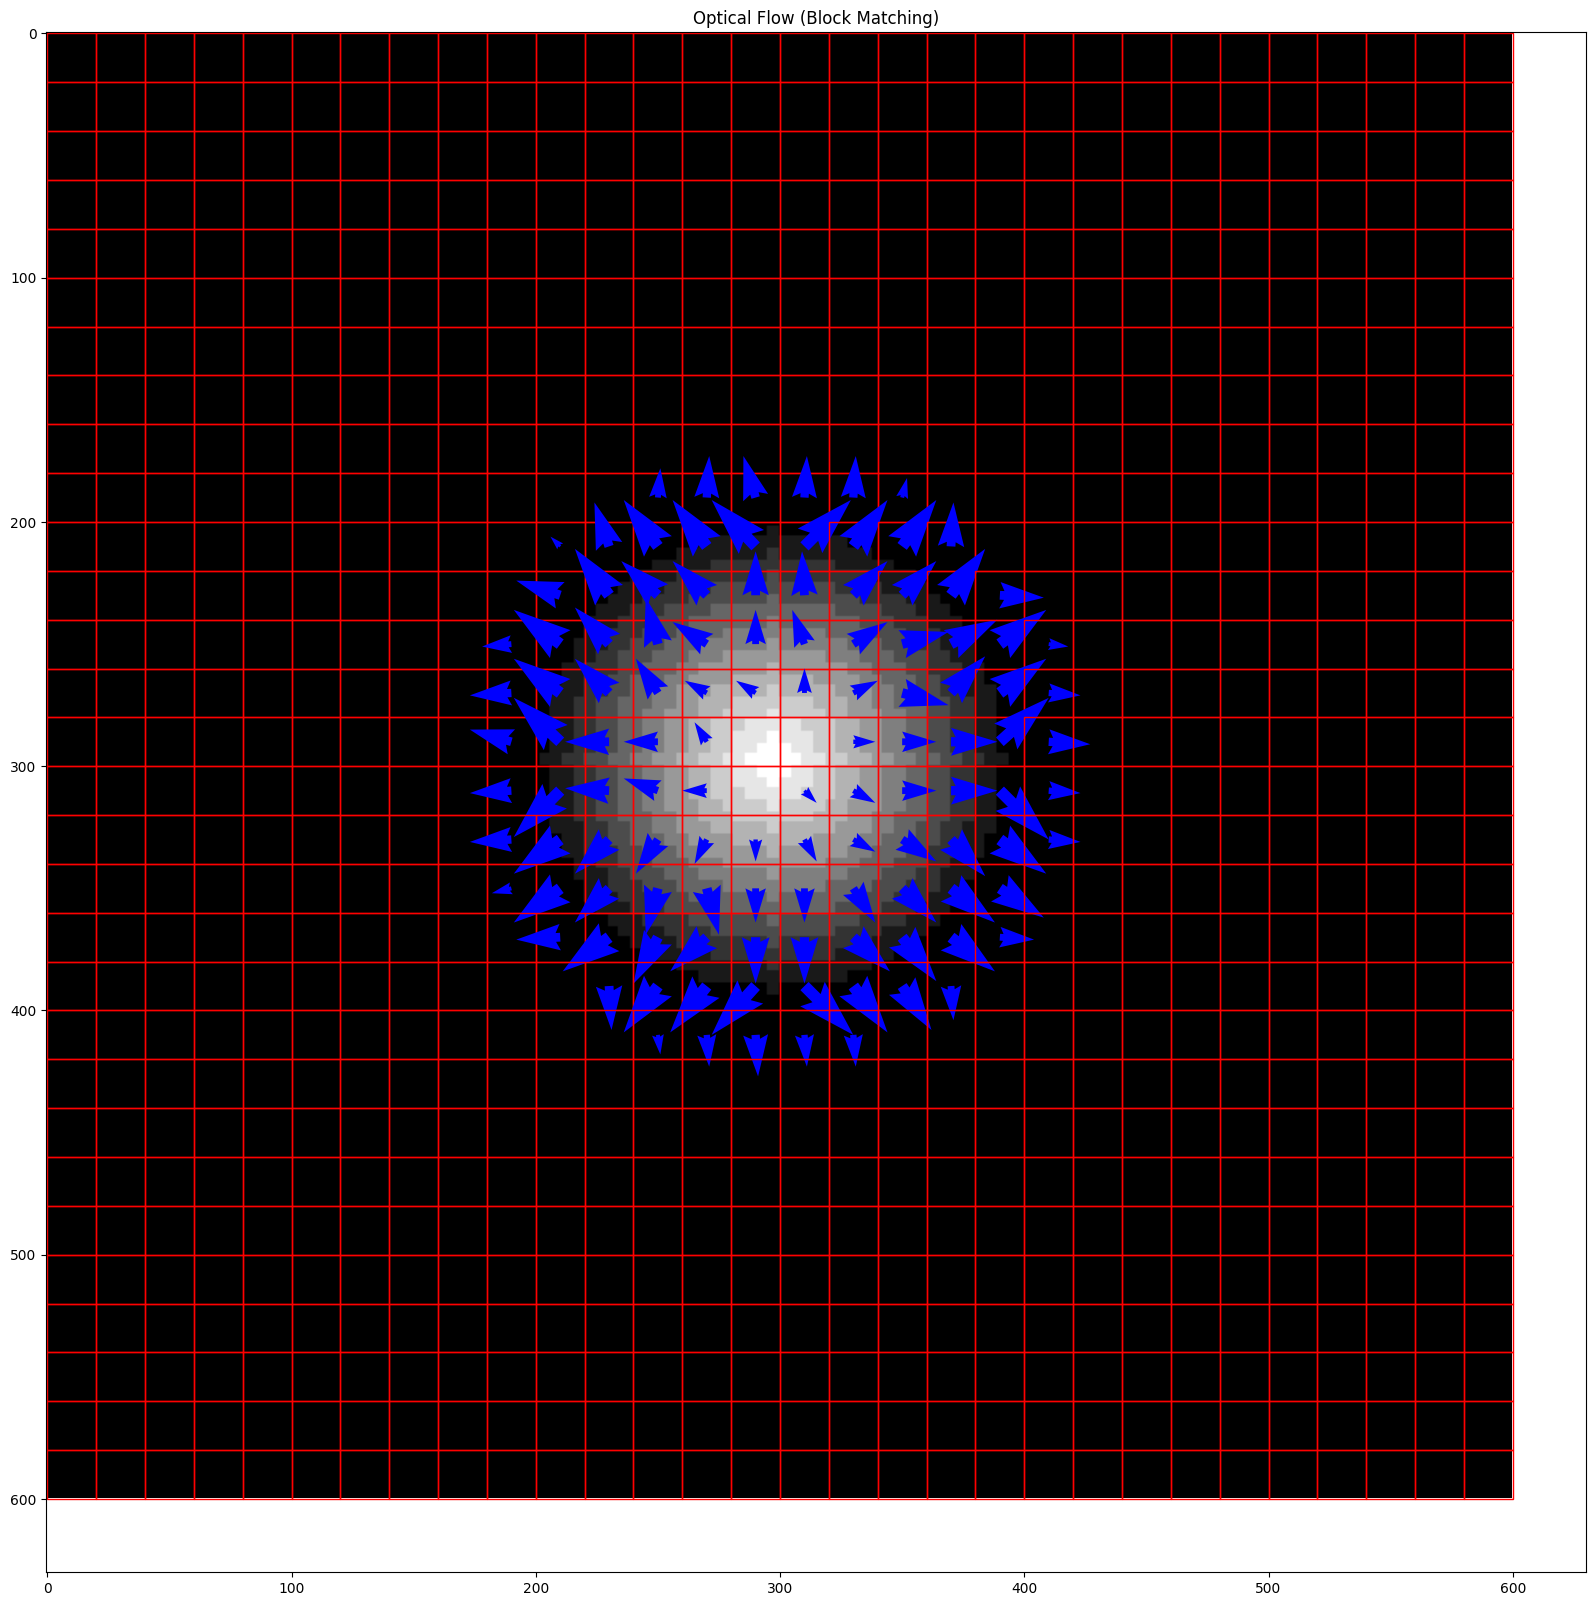

In [9]:
def visualize_block_matching(frame1, frame2, flow_u, flow_v, modified_blocks, block_size=20, figsize=(20, 20), zoom=False):
    _, ax = plt.subplots(figsize=figsize)

    ax.imshow(frame1, cmap='gray')
    ax.imshow(frame2, cmap='gray', alpha=0)

    # Draw rectangles around blocks and plot the optical flow vectors
    for i in range(0, frame1.shape[0] - block_size + 1, block_size):
        for j in range(0, frame1.shape[1] - block_size + 1, block_size):
            rect = patches.Rectangle((j, i), block_size, block_size, linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            if modified_blocks[i // block_size, j // block_size]:
                ax.quiver(j + block_size // 2, i + block_size // 2, flow_u[i // block_size, j // block_size],
                           flow_v[i // block_size, j // block_size], color='b', angles='xy', scale_units='xy', scale=1)

    if zoom:
        plt.xlim(150, 450)
        plt.ylim(150, 450)

    plt.title("Optical Flow (Block Matching)")
    plt.show()

visualize_block_matching(img1, img2, flow_u, flow_v, modified_blocks, block_size=20)

Zoomons pour voir plus en détails:

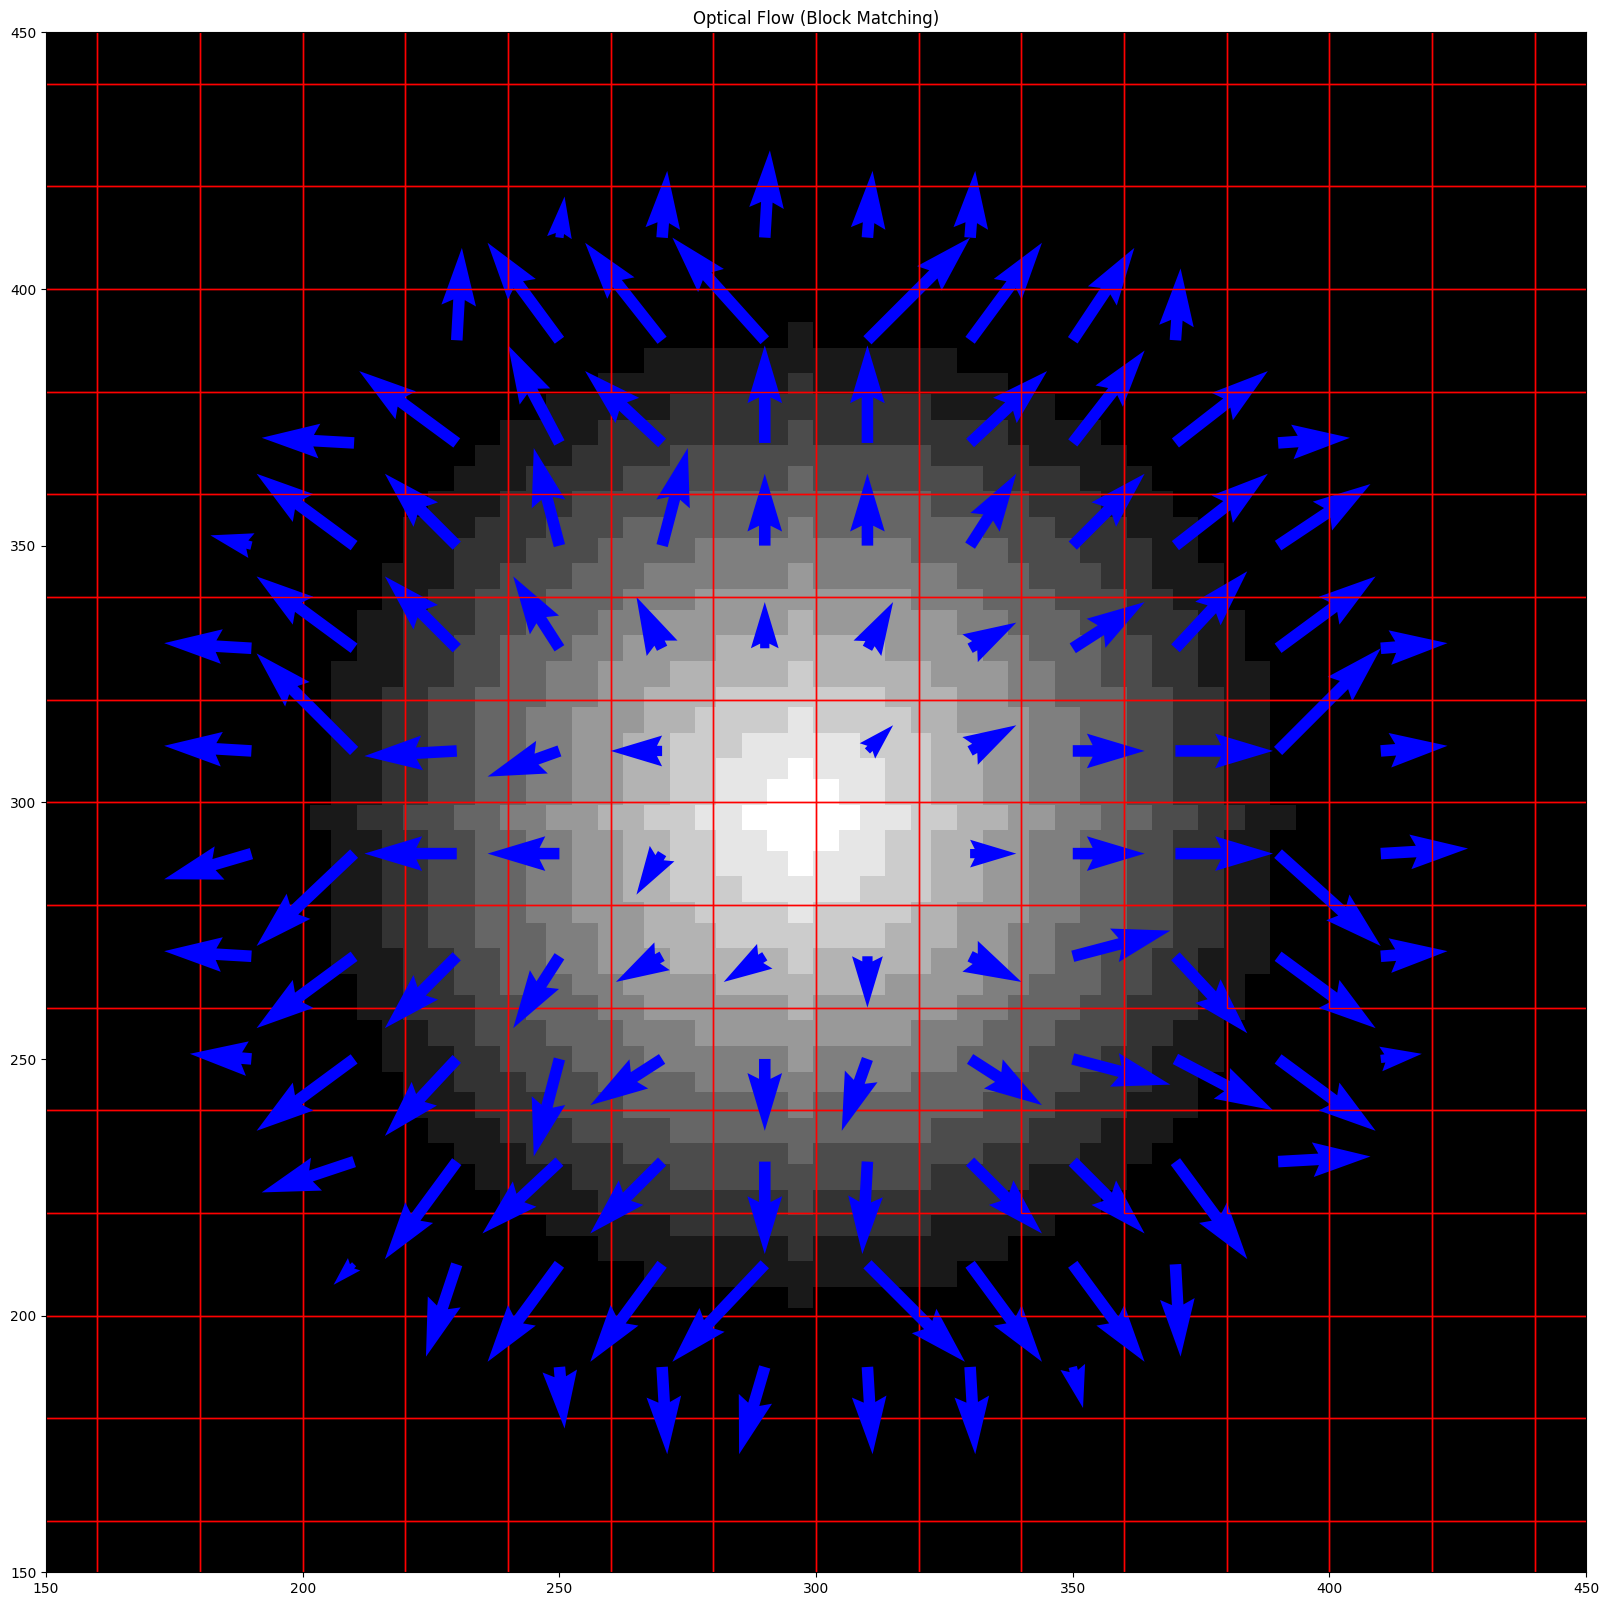

In [10]:
visualize_block_matching(img1, img2, flow_u, flow_v, modified_blocks, block_size=20, zoom=True)

On remarque que la méthode Block Matching (BMA) est moins sensible au bruit par rapport à la méthode pixel-wise. Cependant, la précision de l'estimation dépend de la taille des blocs et de la fenêtre de recherche.

En ajustant la taille des blocs et la fenêtre de recherche, il est possible de trouver un bon compromis entre précision et coût de calcul. Des blocs plus petits augmentent la précision mais nécessitent plus de calculs, tandis que des blocs plus grands réduisent le coût de calcul et peuvent être plus robustes aux variations locales mais par la même occasion manquer de précision.

### (C) Que deduisez-vous des deux premières questions? (régularité du champs de vecteurs de mouvement vs. taille des blocs)

Pour la question (A), j'ai utilisé une méthode pixel-wise pour estimer les vecteurs de mouvement des pixels de la frame F1 vers F2, en supposant une intensité constante. Cela signifie que j'ai calculé le déplacement de chaque pixel individuellement, ce qui peut donner une précision élevée mais peut être coûteux en termes de calcul.

Pour la question (B), j'ai utilisé une estimation par blocs (BMA) pour estimer les vecteurs de mouvement en regroupant les pixels en blocs de différentes tailles. Cette approche réduit la complexité de calcul en considérant le mouvement des blocs plutôt que des pixels individuels. Cependant, cela peut entraîner une perte de précision, notamment dans les zones où le mouvement est non homogène à l'intérieur d'un bloc.

La régularité du champ de vecteurs de mouvement peut varier en fonction de la taille des blocs utilisés dans l'estimation. Des blocs plus grands peuvent conduire à une estimation plus régulière du mouvement, tandis que des blocs plus petits peuvent capturer des détails plus fins mais peuvent également être plus sensibles au bruit.

### (D.1) Rajoutez une méthode de régularisation du champs de vecteurs de mouvement de votre choix parmi les méthodes du cours et discutez pour quelles valeurs de coefficients le champs de vecteurs obtenu semble plus correspondre au flot optique.

Pour cette tâche, nous allons implémenter la méthode de régularisation de Horn-Schunck pour améliorer la continuité du champ de vecteurs de mouvement. La méthode de Horn-Schunck impose une contrainte de lissage pour s'assurer que les vecteurs de mouvement varient en douceur dans l'image.

L'énergie à minimiser est la suivante :

$$E=∑_{x∈Λ}((\frac{\partial \psi}{\partial x}u + \frac{\partial \psi}{\partial y}v + \frac{\partial \psi}{\partial t})^2+α^2(∥∇u∥^2+∥∇v∥^2))$$

Où $α$ est le coefficient de régularisation.

### Calcul des variations et mise à jour

Pour minimiser cette énergie, nous utilisons une méthode itérative basée sur le calcul des variations. Nous recherchons les $u$ et $v$ qui minimisent $E$.

Pour simplifier les calculs, nous définissons :

- $I_x=\frac{\partial\psi}{\partial x}$
- $I_x=\frac{\partial\psi}{\partial y}$
- $I_x=\frac{\partial\psi}{\partial t}$

Ainsi, l'énergie $E$ peut être réécrite comme :

$$E=∑_{x∈Λ}((I_x u + I_y v + I_t)^2+α(∥∇u∥^2+∥∇v∥^2))$$

Pour minimiser $E$, on utilise les équations d'Euler-Lagrange, qui mènent aux itérations suivantes pour $u$ et $v$ :

$$u=u_{avg} − \frac{I_x (I_x u_{avg} + I_y v_{avg} + I_t)}{\alpha^2 + I_x^2 + I_y^2}$$
$$u=v_{avg} − \frac{I_y (I_x u_{avg} + I_y v_{avg} + I_t)}{\alpha^2 + I_x^2 + I_y^2}$$

Où $u_{avg}$ et $v_{avg}$ sont les moyennes de $u$ et $v$ respectivement, obtenues par convolution avec un noyau $3×3$.

La démonstration est disponible sur la page wikipédia de la méthode: https://en.wikipedia.org/wiki/Horn%E2%80%93Schunck_method

In [11]:
def horn_schunck_regularization(img1, img2, u, v, alpha=1, num_iter=25):
    img1 = img1.astype(float)
    img2 = img2.astype(float)

    u = np.copy(u)
    v = np.copy(v)

    Ix = np.gradient(img1, axis=1)
    Iy = np.gradient(img1, axis=0)
    It = img2 - img1

    for _ in range(num_iter):
        # convolution avec un kernel de type:
        # [0, 1, 0]
        # [1, 0, 1]
        # [0, 1, 0]
        u_avg = (np.roll(u, 1, axis=0) + np.roll(u, -1, axis=0) + np.roll(u, 1, axis=1) + np.roll(u, -1, axis=1)) / 4
        v_avg = (np.roll(v, 1, axis=0) + np.roll(v, -1, axis=0) + np.roll(v, 1, axis=1) + np.roll(v, -1, axis=1)) / 4

        P = (Ix * u_avg + Iy * v_avg + It) / (alpha**2 + Ix**2 + Iy**2)

        u = u_avg - Ix * P
        v = v_avg - Iy * P

    return u, v

Commençons par visualiser la méthode point-wise du (A) sans régularisation. On a ici choisi un stride de 4 afin de mieux comprendre l'impact visuel des futures régularisations.

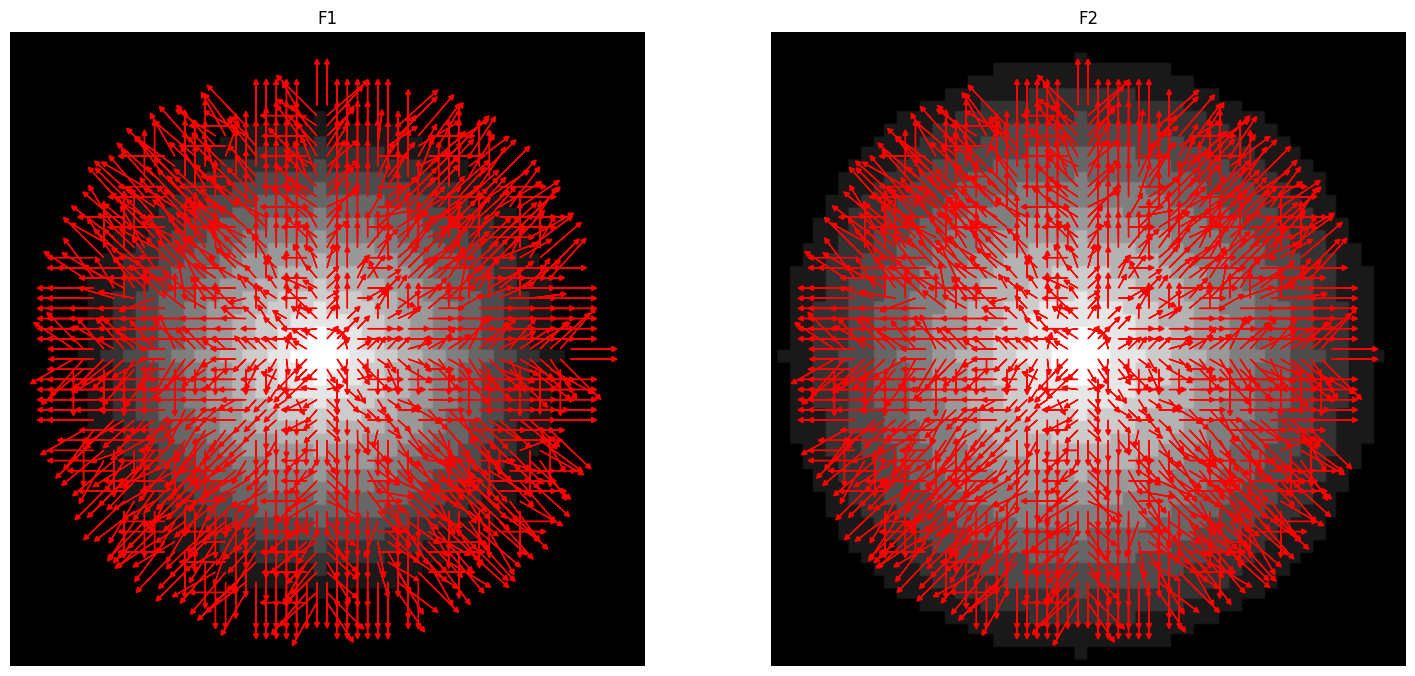

In [12]:
u, v = estimate_optical_flow(img1, img2, window_size=5)
display_optical_flow(img1, img2, u, v, stride=4, zoom=True)

Appliquons une régularisation alpha = 0.1

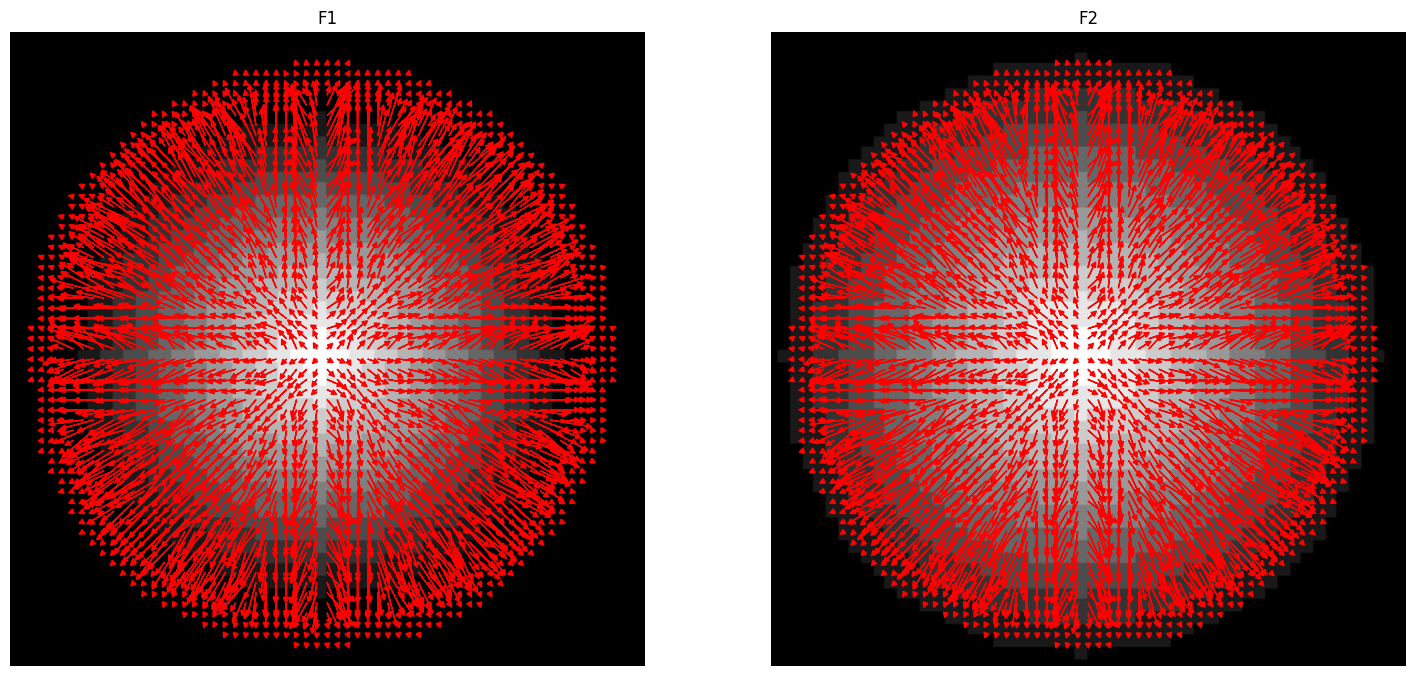

In [13]:
u_2, v_2 = horn_schunck_regularization(img1, img2, u, v, alpha=0.1)
display_optical_flow(img1, img2, u_2, v_2, stride=4, zoom=True)

Appliquons une régularisation alpha = 0.5

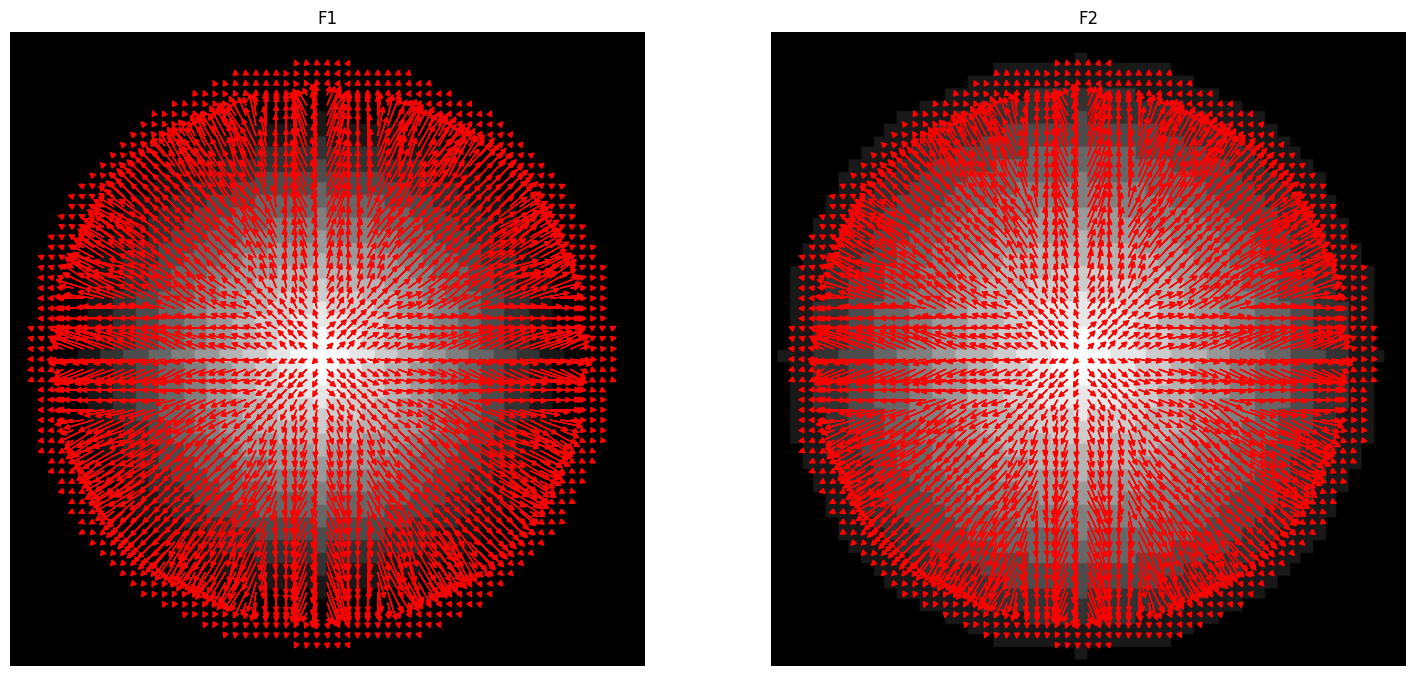

In [14]:
u_2, v_2 = horn_schunck_regularization(img1, img2, u, v, alpha=0.5)
display_optical_flow(img1, img2, u_2, v_2, stride=4, zoom=True)

Appliquons une régularisation alpha = 1.0

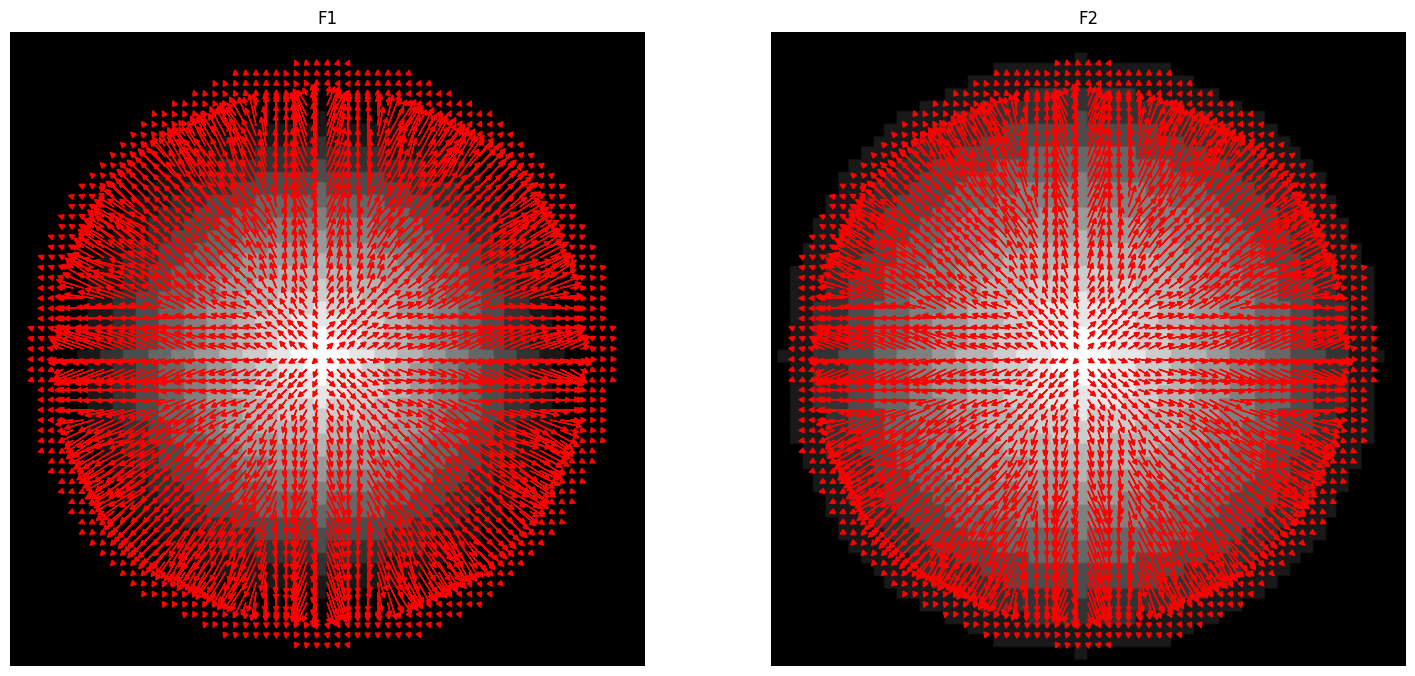

In [15]:
u_2, v_2 = horn_schunck_regularization(img1, img2, u, v, alpha=1)
display_optical_flow(img1, img2, u_2, v_2, stride=4, zoom=True)

**Explication des résultats :**

La méthode de Horn-Schunck impose une régularisation en lissant les vecteurs de mouvement sur l'ensemble de l'image, ce qui donne un champ de vecteurs de mouvement plus régulier. Le coefficient $α$ contrôle le degré de lissage. Parmis les 2 configurations précédemment montrées, on a:

**Petit $α=0.1$ :**

Lorsque $α$ est petit, l'effet de régularisation est faible. En effet, on remarque que le champ de vecteurs de mouvement est moins lissé et  contient plus de bruit ou de variations abruptes. Les estimations de mouvement apparaissent comme étant moins stables.

**Grand $α=1$ :**

Lorsque $α$ est grand, l'effet de régularisation est fort. Le champ de vecteurs de mouvement est plus lisse, réduisant les variations abruptes et le bruit. Cependant, un $α$ trop grand peut lisser les détails importants du mouvement, ce qui peut entraîner une perte de précision dans les estimations de mouvement.

**Visuellement, une valeur intermédiaire de $α$ autour de 0.5 à 1 semble le mieux correspondre au flot optique.**

**Pour aller plus loin:** La même méthode de régularisation mais pour la méthode une de `block_matching` modifiée pour que la régularisation s'applique correctement donne:

In [16]:
def block_matching_bis(img1, img2, block_size=16):
    height, width = img1.shape
    u = np.zeros((height, width))
    v = np.zeros((height, width))

    for y in range(0, height - block_size, block_size):
        for x in range(0, width - block_size, block_size):
            best_match = (0, 0)
            min_cost = float('inf')

            current_block = img1[y:y+block_size, x:x+block_size]
            all_cost = np.zeros((block_size * 2 + 1, block_size * 2 + 1))

            for dy in range(-block_size, block_size + 1):
                for dx in range(-block_size, block_size + 1):
                    ref_y = y + dy
                    ref_x = x + dx

                    if ref_y < 0 or ref_y + block_size > height or ref_x < 0 or ref_x + block_size > width:
                        continue

                    ref_block = img2[ref_y:ref_y+block_size, ref_x:ref_x+block_size]
                    cost = np.sum((current_block - ref_block) ** 2)
                    all_cost[dy + block_size, dx + block_size] = cost

            min_index = find_min_coordinates(all_cost, block_size)

            min_cost = all_cost[min_index[0], min_index[1]]
            current_block = all_cost[block_size + 1, block_size + 1]
            best_match = (min_index[0] - block_size, min_index[1] - block_size)

            if min_cost != current_block and np.linalg.norm(best_match) > 0:
                u[y:y+block_size, x:x+block_size] = best_match[1]
                v[y:y+block_size, x:x+block_size] = best_match[0]

    return u, v

In [17]:
def display_motion(img1, u, v, scale=1, stride=8, regularization=False, zoom=False):
    plt.figure(figsize=(10, 10))
    plt.imshow(img1, cmap='gray')
    for y in range(0, u.shape[0], stride):
        for x in range(0, u.shape[1], stride):
            plt.arrow(x, y, u[y, x] * scale, v[y, x] * scale, color='red', head_width=1, head_length=1)

    if zoom:
        plt.xlim(150, 450)
        plt.ylim(150, 450)
        plt.xlim(150, 450)
        plt.ylim(150, 450)

    plt.title(f'Node-based motion estimation {"with" if regularization else "without"} regularization')
    plt.show()

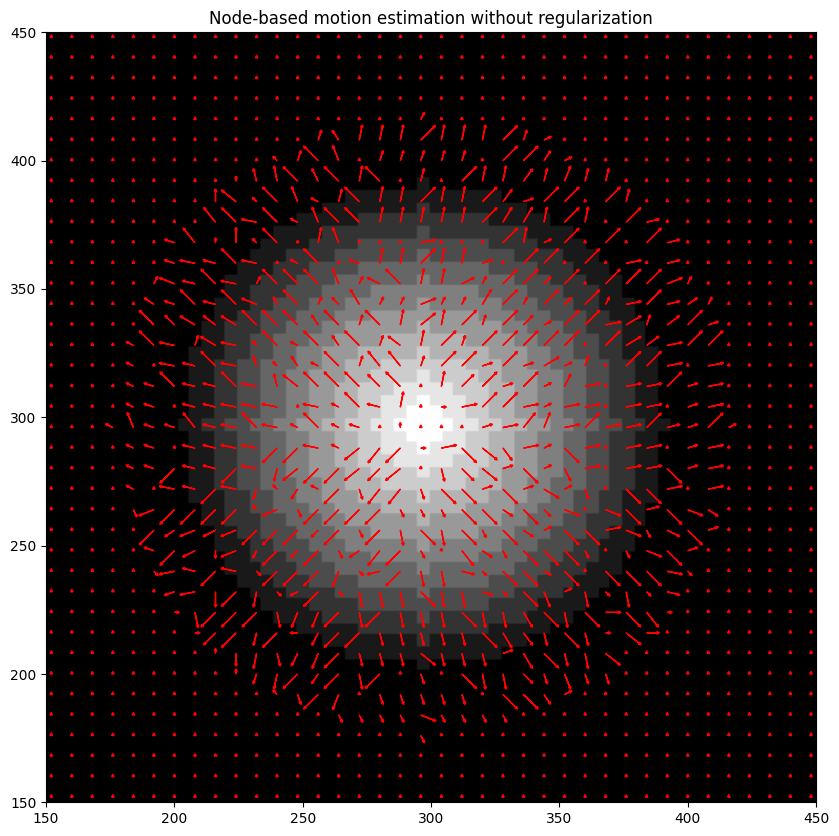

In [18]:
u, v = block_matching_bis(img1, img2, block_size=5)
display_motion(img1, u, v, zoom=True)

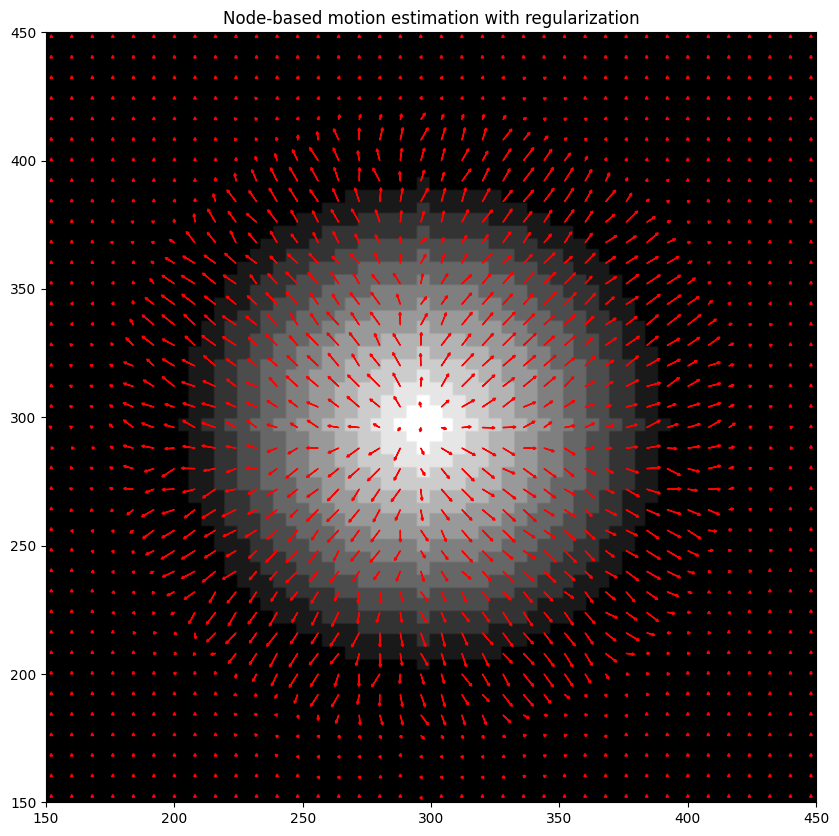

In [19]:
u_reg, v_reg = horn_schunck_regularization(img1, img2, u, v, alpha=0.8)
display_motion(img1, u_reg, v_reg, zoom=True, regularization=True)

Dans cet exemple, on voit visuellement mieux le but but de la régularisation

### (D.2) Refaites une estimation de mouvement mais cette fois-ci en node-base (sans et avec régularisation). Qu’observez vous par rapport a la méthode par blocs ?

Dans cette section, nous allons estimer les vecteurs de mouvement des pixels de la frame F1 vers F2 en utilisant une méthode node-based, à la fois sans et avec régularisation. La méthode node-based consiste à estimer le mouvement pour chaque pixel ou petit groupe de pixels (nœuds), contrairement à la méthode par blocs qui traite des blocs de pixels plus grands.

### Explication de la méthode

D'après le cours, la fonction `calculate_phi` calcule un vecteur de poids basé sur la position d'un point dans un bloc.

1. **Définition de la constante** :
    - $ Cte = (x_{max} - x_{min}) \times (y_{max} - y_{min}) $

2. **Calcul des poids** :
    - $ \phi_0 = \frac{(x - x_{min}) \times (y - y_{min})}{Cte} $
    - $ \phi_1 = \frac{(x_{max} - x) \times (y - y_{min})}{Cte} $
    - $ \phi_2 = \frac{(x - x_{min}) \times (y_{max} - y)}{Cte} $
    - $ \phi_3 = \frac{(x_{max} - x) \times (y_{max} - y)}{Cte} $

La fonction retourne le vecteur $\phi = [\phi_0, \phi_1, \phi_2, \phi_3]$.

Par la suite, dans la fonction `node_based_motion_estimation`, on estime le mouvement basé sur des blocs d'image. Les étapes abordées sont les suivantes:

1. **Calcul pour chaque bloc** :
    - Pour chaque bloc, on initialisase les vecteurs de déplacement locaux $d_u$ et $d_v$ ainsi que des gradients de l'erreur $grad_{E_u}$ et $grad_{E_v}$.

3. **Calcul des gradients d'erreur** :
    - Pour chaque pixel du bloc, on calcule les poids $\phi$ (avec `calculate_phi`)
    - On calcule les nouvelles positions estimées $ x2_u $ et $ y2_u $ pour $ u $ et $ x2_v $ et $ y2_v $ pour $ v $.
    - On retrouve ensuite la différence d'intensité entre les images $ It_u $ et $ It_v $.
    - Mise à jour des gradients d'erreur $ grad_{E_u} $ et $ grad_{E_v} $ en utilisant les poids $\phi$.

4. **Mise à jour des déplacements** :
    - Mise à jour des vecteurs de déplacement locaux $ d_u $ et $ d_v $ en utilisant le taux d'apprentissage (définit en hyper paramètre).

5. **Application des déplacements** :
    - Pour chaque pixel du bloc, on applique des déplacements en utilisant les poids $\phi$ pour mettre à jour les matrices de mouvement $ u $ et $ v $.

In [20]:
def calculate_phi(x, y, xmin, xmax, ymin, ymax):
    Cte = (xmax - xmin) * (ymax - ymin)
    phi = np.zeros(4)
    phi[0] = (x - xmin) * (y - ymin) / Cte
    phi[1] = (xmax - x) * (y - ymin) / Cte
    phi[2] = (x - xmin) * (ymax - y) / Cte
    phi[3] = (xmax - x) * (ymax - y) / Cte
    return phi

In [21]:
def node_based_motion_estimation(img1, img2, block_size=20, lr=0.4):
    height, width = img1.shape

    u = np.zeros((height, width))
    v = np.zeros((height, width))

    for y in range(0, height - block_size + 1, block_size):
        for x in range(0, width - block_size + 1, block_size):
            d_u = np.zeros(4)
            d_v = np.zeros(4)

            grad_E_u = np.zeros(4)
            grad_E_v = np.zeros(4)

            for i in range(block_size):
                for j in range(block_size):
                    phi = calculate_phi(x + j, y + i, x, x + block_size, y, y + block_size)
                    x2_u = x + j + np.sum(phi * d_u)
                    y2_u = y + i + np.sum(phi * d_u)
                    x2_v = x + j + np.sum(phi * d_v)
                    y2_v = y + i + np.sum(phi * d_v)

                    if 0 <= x2_u < width and 0 <= y2_u < height:
                        It_u = img2[int(y2_u), int(x2_u)] - img1[y + i, x + j]
                        grad_E_u += phi * It_u

                    if 0 <= x2_v < width and 0 <= y2_v < height:
                        It_v = img2[int(y2_v), int(x2_v)] - img1[y + i, x + j]
                        grad_E_v += phi * It_v

            d_u -= lr * grad_E_u
            d_v -= lr * grad_E_v

            for i in range(block_size):
                for j in range(block_size):
                    phi = calculate_phi(x + j, y + i, x, x + block_size, y, y + block_size)
                    u[y + i, x + j] = np.sum(phi * d_u)
                    v[y + i, x + j] = np.sum(phi * d_v)

    return u, v

In [22]:
def plot_motion_shapes(img1, u, v, block_size=20, stride=20, zoom=False):
    _, axes = plt.subplots(1, 2, figsize=(15, 15))

    axes[0].imshow(img1, cmap='gray')
    axes[0].set_title('F2 with node base block estimation')
    axes[0].axis('off')
    axes[1].imshow(img1, cmap='gray')
    axes[1].set_title('F2 with vectors visualization with node base')
    axes[1].axis('off')

    y, x = np.mgrid[0:u.shape[0], 0:u.shape[1]]

    for y1 in range(0, u.shape[0], stride):
        for x1 in range(0, u.shape[1], stride):
            x2 = x1 + int(u[y1, x1])
            y2 = y1 + int(v[y1, x1])

            if 0 <= x2 < img1.shape[1] and 0 <= y2 < img1.shape[0]:
                rect2 = plt.Rectangle((x2, y2), block_size, block_size, edgecolor='blue', facecolor='none')
                axes[0].add_patch(rect2)
                con = plt.Line2D((x1, x2), (y1, y2), color='green')
                axes[0].add_line(con)

    axes[1].quiver(x[::stride, ::stride], y[::stride, ::stride], u[::stride, ::stride], v[::stride, ::stride], color='red', units='xy', scale=1)

    if zoom:
        axes[0].set_xlim(150, 450)
        axes[0].set_ylim(150, 450)
        axes[1].set_xlim(150, 450)
        axes[1].set_ylim(150, 450)

    plt.title('Node-based motion estimation')
    plt.tight_layout()
    plt.show()

Sans la régularisation:

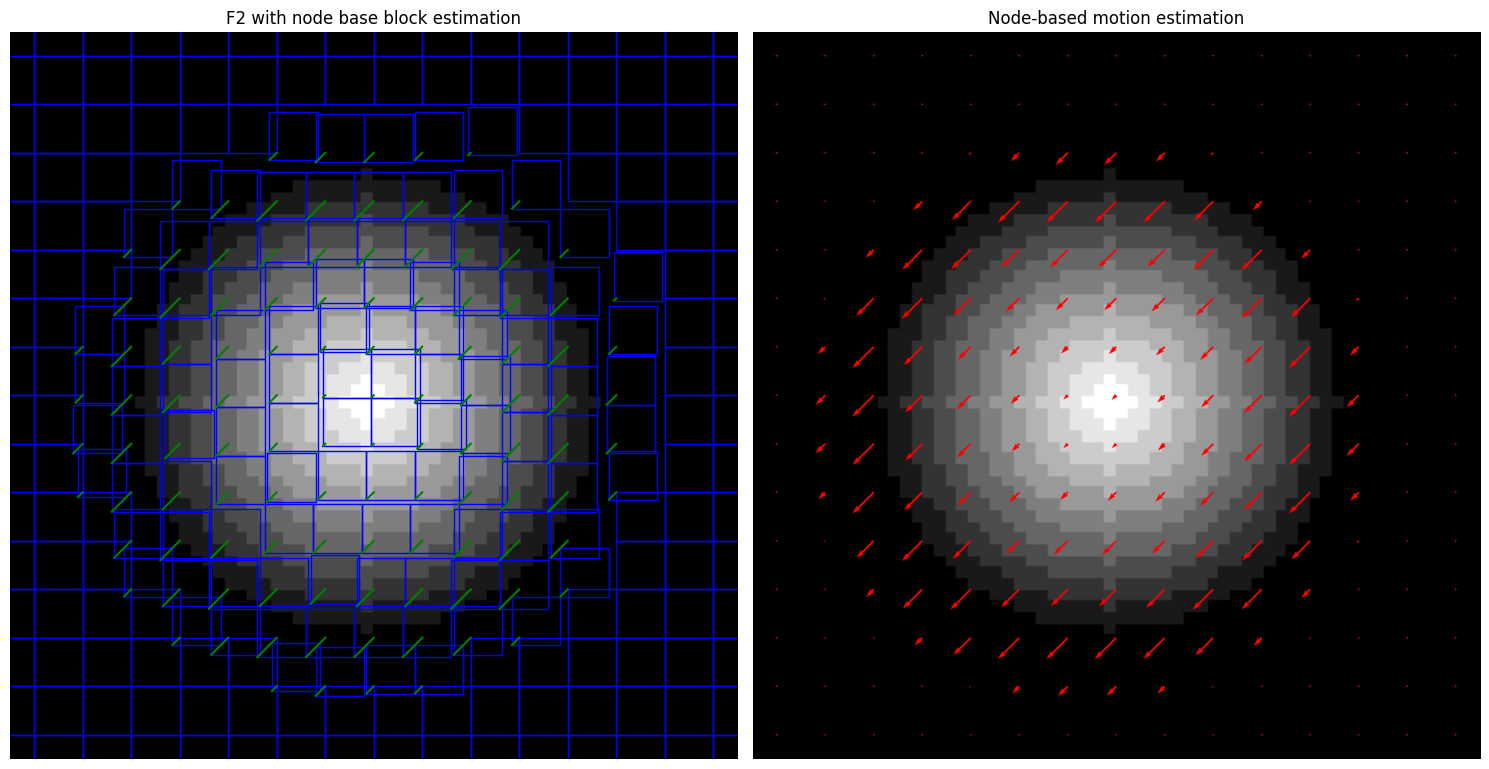

In [23]:
u, v = node_based_motion_estimation(img1, img2, block_size=20)
plot_motion_shapes(img1, u, v, block_size=20, zoom=True)

Avec la régularisation:

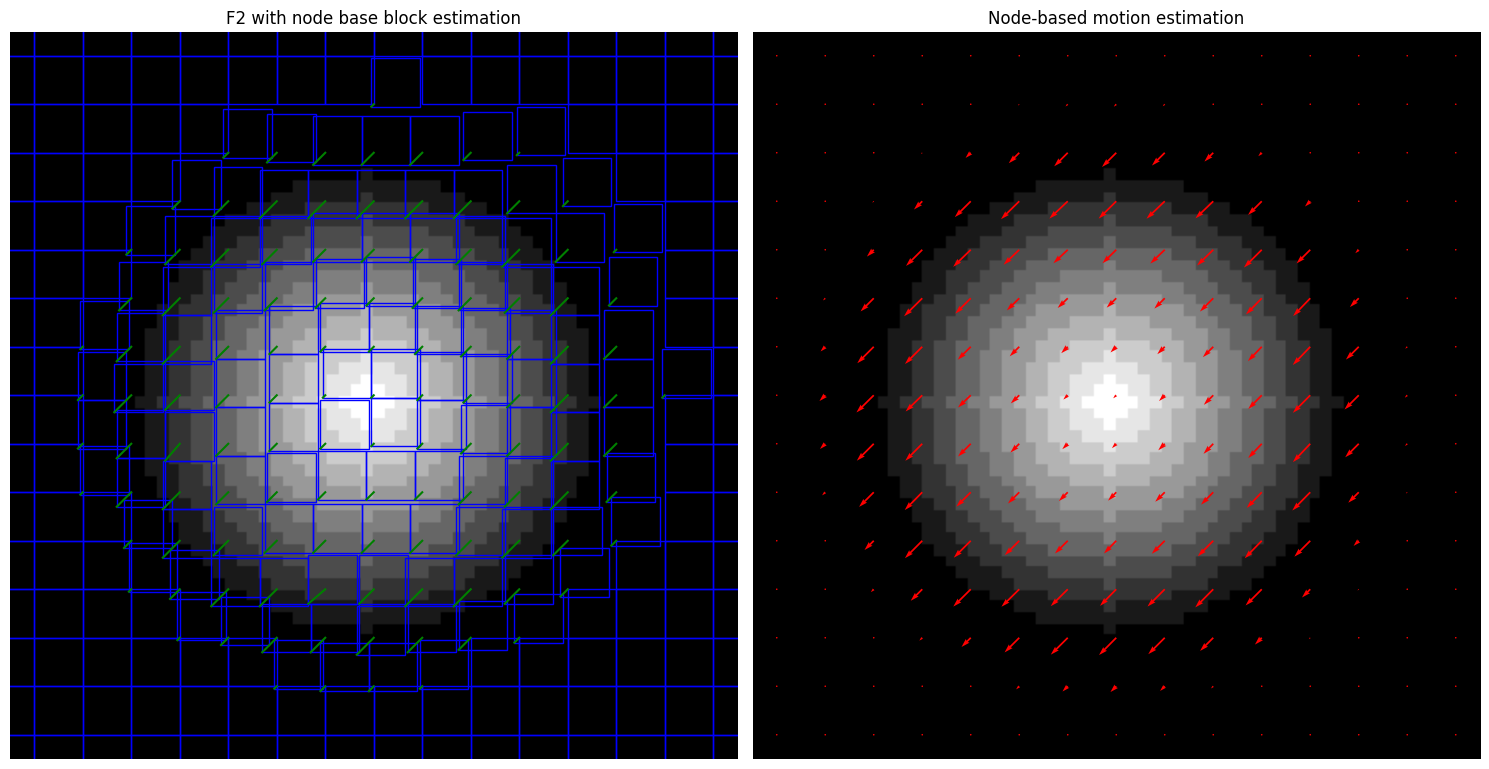

In [24]:
u_reg, v_reg = horn_schunck_regularization(img1, img2, u, v, alpha=0.8)
plot_motion_shapes(img1, u_reg, v_reg, block_size=20, zoom=True)

Je n'ai pas réussi à correctement appliquer la méthode node-based. Mais elle semble offrir une alternative précise et détaillée pour l'estimation de mouvement par rapport à la méthode par blocs.

En comparant avec la méthode par blocs, la méthode node-based est plus précise mais également plus complexe et sensible au bruit.